# Исследование данных о компьютерных играх

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import stats as st


In [2]:
display(HTML("<style>.container { width:70% !important; <style>}"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('E:/BuduBogatym/games.csv')

## Предобработка данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


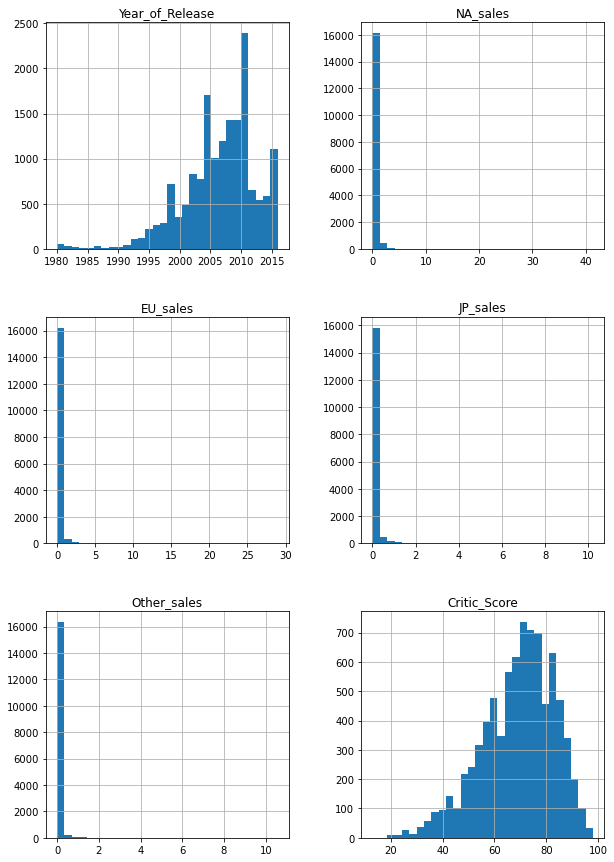

In [5]:
data.hist(figsize = (10,15), bins = 30);# Построение гистограмм для всех столбцов

### Устранение пропусков

In [6]:
data.columns = data.columns.str.lower()# Понижение регистра заголовков столбцов

In [7]:
data.isna().sum()# Количество пропусков в каждом столбце

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

**Возможные причины возникновения пропусков в стобцах:**


    
 * `name` - Скорее всего здесь техническая ошибка передачи данных.
 * `year_of_release` - Вероятно, год не был указан из-за человеческого фактора - просто забыл.
 * `genre ` - Аналогичная ситуация с `name`, так как число пропусков совпадает.
 * `critic_score` - Так как это оценка критиков, то очень странно, что она отсутствует, однако предположу, что оценки отсутствую в старых играх
 * `user_score`,`rating` - Ситуация аналогична `critic_score`, здесь просто нет оценок на старые игры, либо же в случае `user_score` - люди просто могли забыть про оценку и не дать её.

    



 * Столбцы`critic_score`, `user_score` некорректно заполнять средним или медианным значением, так как присутствует слишком большое количество пропусков и их замена на возможные для нас значения приведёт к некорректной оценки данных в будущем.  
 * В столбцу `raiting` невозможно произвести замену, так как игры с пропусков в данном пункте были созданы до создания ESRB, а мы не имеем возможности заменить их на имеющиеся у нас варианты замены, так как это помешает анализу данных.
    

**Заполним пропуски в данных**

In [8]:
# Удалим строки с пропущенными названиями игр и пропущенными годами.
data.dropna(subset = ['name','year_of_release'],inplace = True)
# Заменим NaN в столбце Rating
data.loc[data['rating'].isna(), 'rating'] = 'unknown'

In [9]:
data.isna().sum() # Проверим пропуски после удаления строк

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

### Изменение типов данных

In [10]:
data.user_score.unique() # Проверим уникальные значения столбца с оценкой пользователей.

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [11]:
data['user_score'].loc[data['user_score'] == 'tbd'] = np.nan# Заменим неизвестные значение tbd на NaN

In [12]:
data.user_score = data.user_score.astype('float')
data.year_of_release = data.year_of_release.astype('int')

### Добавление столбцов

In [13]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data.head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,unknown,28.31


## Исследовательский анализ данных

### Определим актуальный период данных

In [14]:
# Создадим сводную таблицу, показывающую количество игр, выпущенных в разные годы
pivot_years = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
display(pivot_years)

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15




Можно заметить, что примерно до 1993 года выпускалось крайне мало игр, поэтому данный период времени упустим в исследовании.

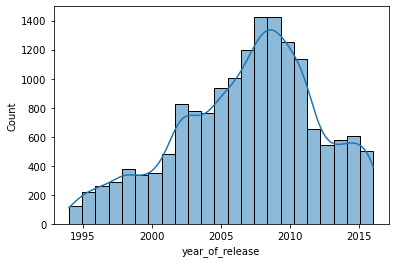

In [15]:
data = data.loc[data['year_of_release'] > 1993]
sns.histplot(data = data['year_of_release'], kde=True, bins = 23 );


    
По данным гистограммы можно сделать вывод, что количество релизов резко сократилось после 2011 года.

In [16]:
# Создадим сводную таблицу, описывающую продажи по платформам
pivot_platform = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales',ascending = False)
display(pivot_platform)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


    
Выберем платформы с наибольшими суммарными продажами и построим распределение по годам.

In [17]:
display(pivot_platform.head(10))

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [18]:
# Построим сводную таблицу продаж платформ по годам
pivot_platform = data.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
display(pivot_platform)

,platform,year_of_release,total_sales
0,3DO,1994,0.02
1,3DO,1995,0.08
2,3DS,2011,63.20
3,3DS,2012,51.36
4,3DS,2013,56.57
5,3DS,2014,43.76
6,3DS,2015,27.78
7,3DS,2016,15.14
8,DC,1998,3.38
9,DC,1999,5.16


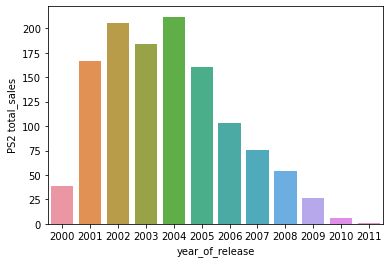

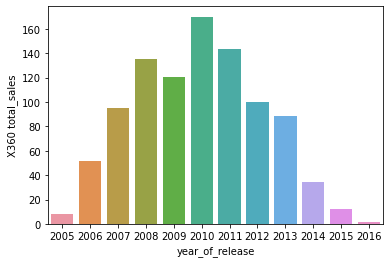

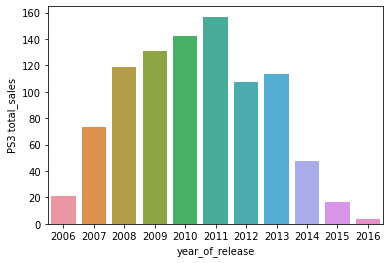

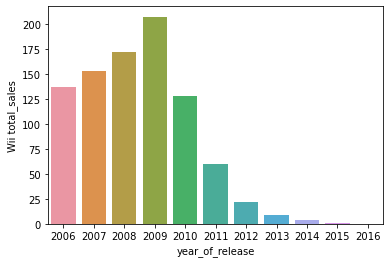

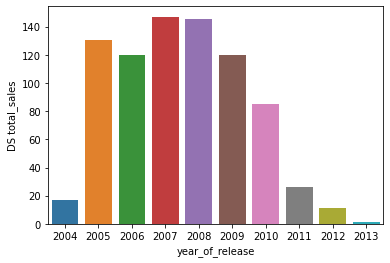

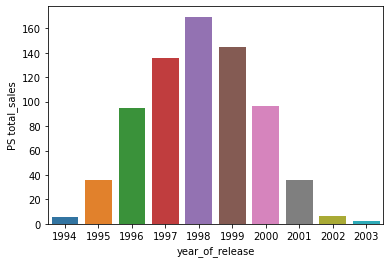

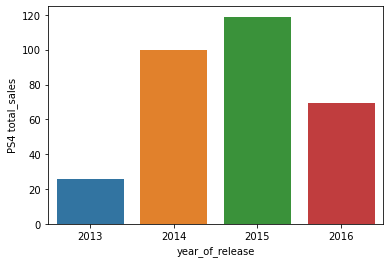

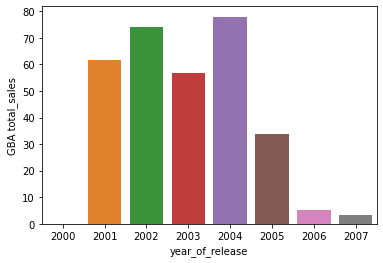

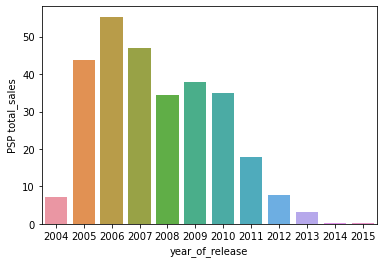

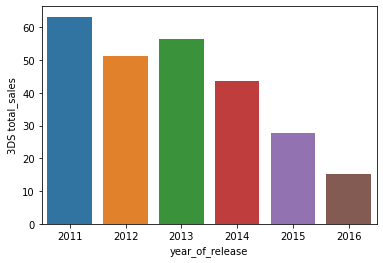

In [19]:
# Построим гистограммы суммарных продаж платформ по годам
unique_platform = ['PS2','X360','PS3','Wii','DS','PS','PS4','GBA','PSP','3DS']
for i in unique_platform:
    data_hist = pivot_platform.loc[pivot_platform['platform'] == i]
    plt.show(sns.barplot(x = data_hist['year_of_release'], y = data_hist['total_sales']).set(ylabel = i + ' total_sales'))



    
Согласно приведенным столбчатым диаграммам можно сделать вывод, что харакретный срок появления новых и начало исчезновения старых платформ в районе 6-7 лет. Яркий этому пример консоли PlayStation. Так как пик популярности приходит к платформе за 3-4 года, то актуальным периодом выберем **2013-2016 года**. Проделаем аналогичные действия с новым актуальным периодом.

### Анализ актуального периода

In [20]:
# Получим актуальный период и построим сводную таблицу по нему для суммарных продаж платформ
data_actual = data.loc[data['year_of_release'] > 2012]
pivot_platform = data_actual.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales',ascending = False)
display(pivot_platform)


,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


In [21]:
pivot_platform = data_actual.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
display(pivot_platform)

,platform,year_of_release,total_sales
0,3DS,2013,56.57
1,3DS,2014,43.76
2,3DS,2015,27.78
3,3DS,2016,15.14
4,DS,2013,1.54
5,PC,2013,12.38
6,PC,2014,13.28
7,PC,2015,8.52
8,PC,2016,5.25
9,PS3,2013,113.25


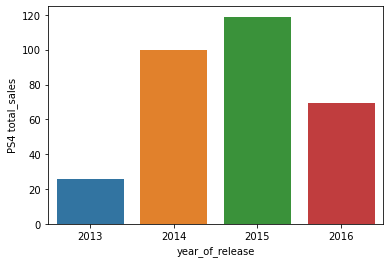

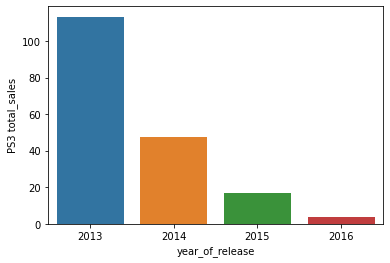

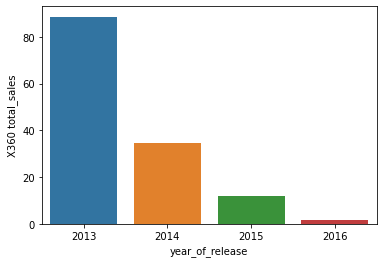

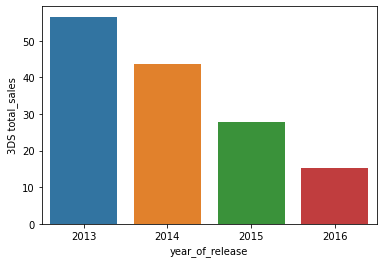

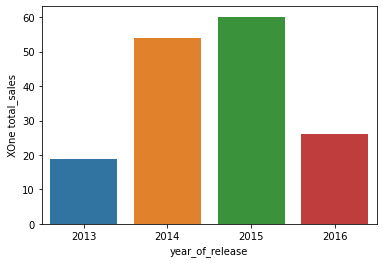

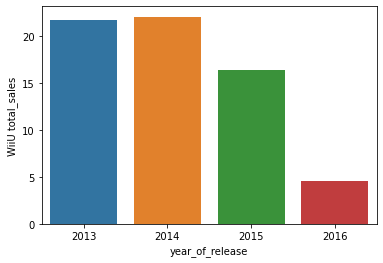

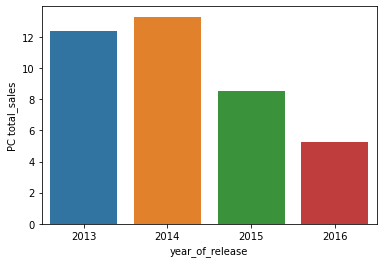

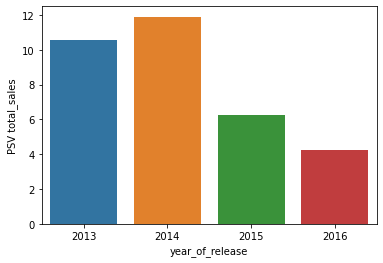

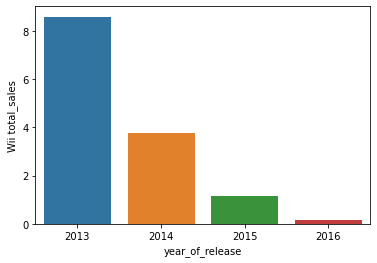

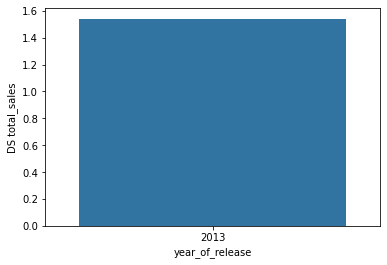

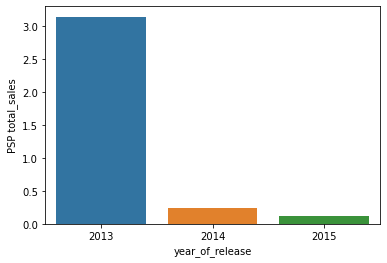

In [22]:
# Построим гистограммы суммарных продаж платформ по годам
unique_platform = ['PS4','PS3','X360','3DS','XOne','WiiU','PC','PSV','Wii','DS','PSP']
for i in unique_platform:
    data_hist = pivot_platform.loc[pivot_platform['platform'] == i]
    plt.show(sns.barplot(x = data_hist['year_of_release'], y = data_hist['total_sales']).set(ylabel = i + ' total_sales'))


    
На основе новых столбчатых диаграмм можно увидеть явных аутсайдеров по продажам в лице DS, PSP, так как их продажи совсем упали к 2016 году. По оставшимся платформам можно сделать вывод о том, что в большинстве случаев продажи после 2015 года резко упали, хотя до этого года уверенно росли.   
В итоге можно выделить следующие платформы: 
* PS3
* X360
* PS4
* 3DS
* DS
* XOne
* WiiU
* Wii
* PC
    

Построим диаграмму размаха по глобальным продажам игр в зависимости от платформы

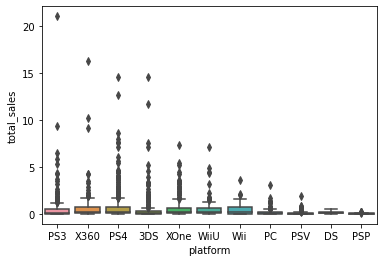

In [23]:
sns.boxplot(x = 'platform', y = 'total_sales', data = data_actual);

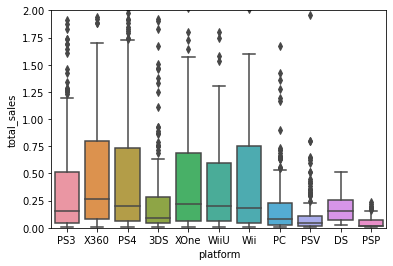

In [24]:
# Построим дополнительный график, чтобы точнее видеть медиану и 75% квантиль.
sns.boxplot(x = 'platform', y = 'total_sales', data = data_actual).set(ylim = (0, 2));


    
Медианные значения всех платформ из вышеперечисленных находится на примерно одинаковом уровне (диапозон их колебаний мал, в сравнении с выбросами), однако можно проследить большое количество аномальных значений у таких платформ как:
* PS3
* X360
* PS4
* 3DS
* XOne
* WiiU
* Wii
* PC  
---
Предполагаю, что это связано с отдельными популярными сериями игр, пользующимися большим спросом, а также эксклюзивные игры для определенных платформ.
    
    
  

Проверим зависимость продаж от оценки пользователей и критиков для самой популярной платформы на 2016 год - PS4

коэффициент корреляции по оценкам критиков: 0.40656790206178123


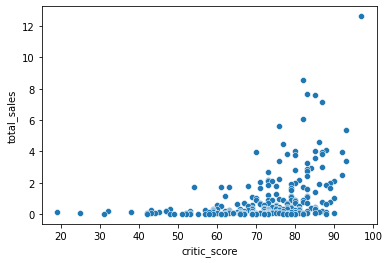

In [25]:
print('коэффициент корреляции по оценкам критиков:', data_actual.query('platform == "PS4"')['total_sales'].corr(data['critic_score']))
sns.scatterplot(data = data_actual.query('platform == "PS4"'), x = 'critic_score', y = 'total_sales');

коэффициент корреляции по оценкам пользователей: -0.03195711020455643


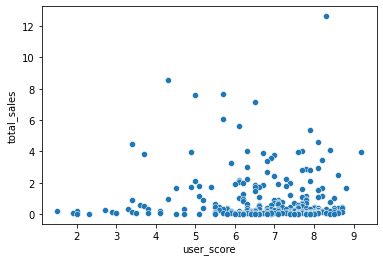

In [26]:
# получим коэффициенты корреляции для PS4 и построим диаграмму рассеяния.
print('коэффициент корреляции по оценкам пользователей:', data_actual.query('platform == "PS4"')['total_sales'].corr(data['user_score']))
sns.scatterplot(data = data_actual.query('platform == "PS4"'), x = 'user_score', y = 'total_sales');


    
По построенным диаграммам рассеяния для PS4 можно сделать вывод, что продажи игр никак не зависят от оценок пользователей, но имею умеренную корреляцию в зависимости от оценок критиков, однако на первой диаграмме можно проследить некоторый рост зависимости при оценке больше 60.

коэффициент корреляции по оценкам критиков платформы X360 : 0.3503445460228664
коэффициент корреляции по оценкам пользователей X360 : -0.011742185147181334


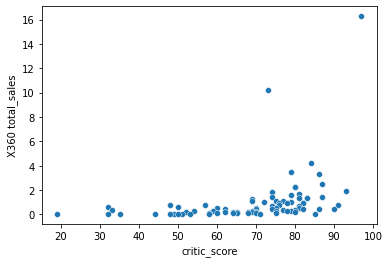

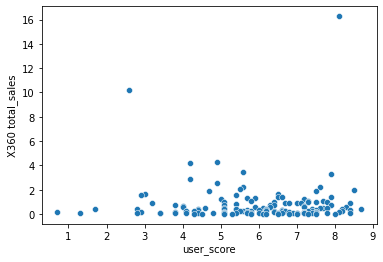

коэффициент корреляции по оценкам критиков платформы PS3 : 0.33428533933719184
коэффициент корреляции по оценкам пользователей PS3 : 0.0023944027357567033


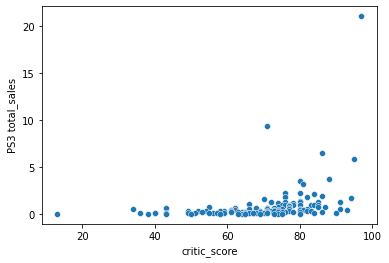

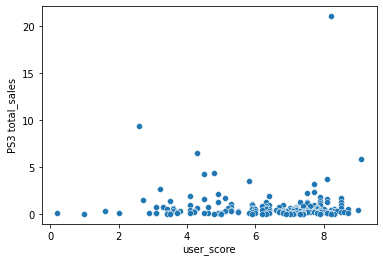

коэффициент корреляции по оценкам критиков платформы 3DS : 0.3570566142288104
коэффициент корреляции по оценкам пользователей 3DS : 0.24150411773563002


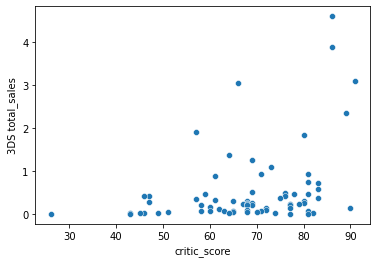

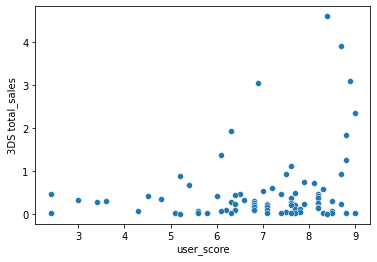

коэффициент корреляции по оценкам критиков платформы XOne : 0.41699832800840153
коэффициент корреляции по оценкам пользователей XOne : -0.06892505328279418


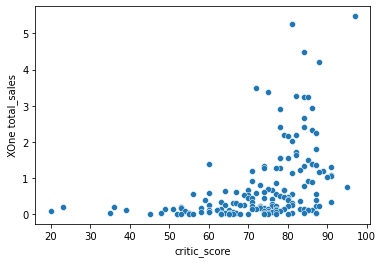

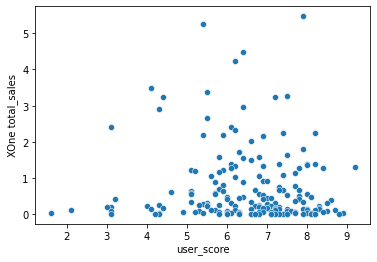

коэффициент корреляции по оценкам критиков платформы WiiU : 0.37641490654239124
коэффициент корреляции по оценкам пользователей WiiU : 0.41933048192661854


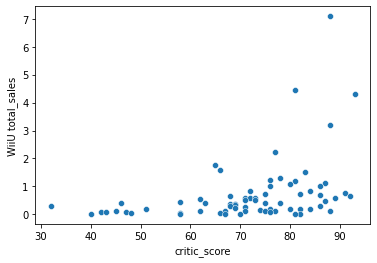

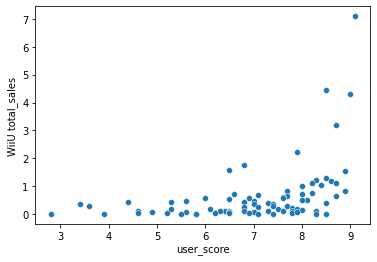

коэффициент корреляции по оценкам критиков платформы Wii : nan
коэффициент корреляции по оценкам пользователей Wii : 0.6829417215362368


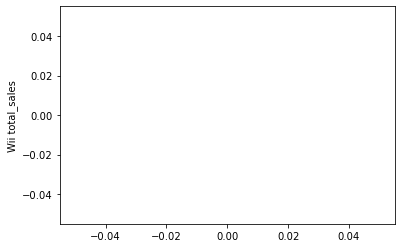

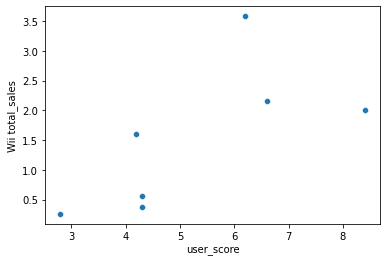

коэффициент корреляции по оценкам критиков платформы PC : 0.19603028294369368
коэффициент корреляции по оценкам пользователей PC : -0.09384186952476747


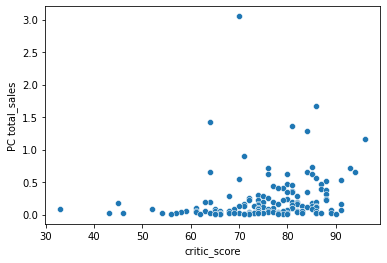

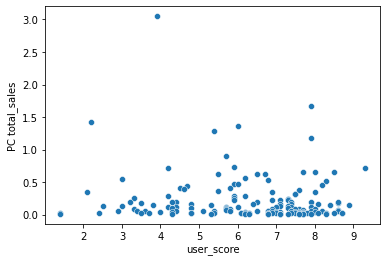

In [27]:
# Проделаем аналогичную операцию верхней для оставшихся платформ.
other_popular_platform = ['X360', 'PS3', '3DS', 'XOne', 'WiiU', 'Wii', 'PC']
for i in other_popular_platform:
    print('коэффициент корреляции по оценкам критиков платформы',i,':', data_actual.query('platform == @i')['total_sales'].corr(data['critic_score']))
    print('коэффициент корреляции по оценкам пользователей',i,':', data_actual.query('platform == @i')['total_sales'].corr(data['user_score']))
    plt.show(sns.scatterplot(data = data_actual.query('platform == @i'), x = 'critic_score', y = 'total_sales').set(ylabel = i + ' total_sales'));
    plt.show(sns.scatterplot(data = data_actual.query('platform == @i'), x = 'user_score', y = 'total_sales').set(ylabel = i + ' total_sales'));
    


    
* На основе выведенных диаграмм рассеяния можно проследить абсолютно идентичные результаты в отношении таких платформ как X360, PS3, XOne.  
* Что касаемо остальных платформ то корреляции по оценкам критиков также умеренны, а вот зависимость от оценок пользователей для 3DS, WiiU, PC уже доросла до слабой, однако у PC она стала отрицательной.
* Также данные по Wii ведут себя очень странно, а данные по оценкам критиков вовсе отсутствуют.

,genre,name
0,Action,766
1,Role-Playing,292
2,Adventure,245
3,Sports,214
4,Shooter,187
5,Misc,155
6,Racing,85
7,Fighting,80
8,Platform,74
9,Simulation,62


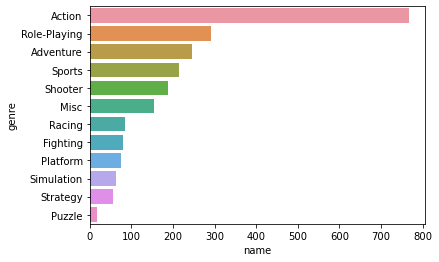

In [28]:
# Построим диаграмму распределения количества игр по жанрам.
pivot_genre = data_actual.pivot_table(index = 'genre', values = 'name', aggfunc = 'count').sort_values(by = 'name', ascending = False).reset_index()
display(pivot_genre)
sns.barplot(x = pivot_genre['name'], y = pivot_genre['genre']);

,genre,total_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125
5,Racing,0.120
6,Action,0.110
7,Simulation,0.100
8,Misc,0.100
9,Strategy,0.080


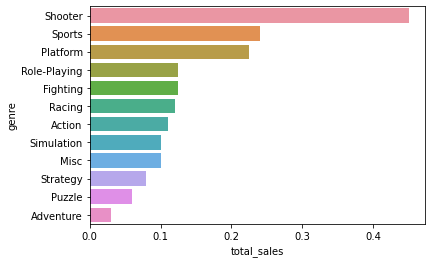

In [29]:
# Построим диаграмму распределения общих продаж по жанрам.
pivot_sales = data_actual.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values(by = 'total_sales', ascending = False).reset_index()
display(pivot_sales)
sns.barplot(x = pivot_sales['total_sales'], y = pivot_sales['genre']);


    
По представленным диаграммам можно сделать следующие выводы:  
* Несмотря на лидирование количества игр у жанра `Action`, его продажи оставляют желать лучшего
* Количество игр в определенном жанре никак не характеризует их продоваемость.
* Жанр `Adventure`, имяя высокую позицию по количеству игр занимет худшее положение среди продаж.  
---
В итоге на основании вышеприведенных данных можно выделить такие жанры как `Shooter`, `Sports`, `Platform`, `Role_Playing`, `Fighting`.

## Портрет пользователя каждого региона

### Анализ продаж по платформам в различных регионах

In [30]:
# Определим топ 5 платформ для каждого региона по продажам
regions = ['na_sales', 'eu_sales','jp_sales']
for i in regions:
    popular_platform = data_actual.pivot_table(index = 'platform', values = i, aggfunc = 'sum').sort_values(by = i, ascending = False).head().reset_index()
    print('Сумма продаж по региону в топ-5 платформ:',popular_platform[i].sum())
    display(popular_platform)
                                           

Сумма продаж по региону в топ-5 платформ: 385.21999999999997


,platform,na_sales
0,PS4,108.74
1,XOne,93.12
2,X360,81.66
3,PS3,63.50
4,3DS,38.20


Сумма продаж по региону в топ-5 платформ: 333.96999999999997


,platform,eu_sales
0,PS4,141.09
1,PS3,67.81
2,XOne,51.59
3,X360,42.52
4,3DS,30.96


Сумма продаж по региону в топ-5 платформ: 136.59


,platform,jp_sales
0,3DS,67.81
1,PS3,23.35
2,PSV,18.59
3,PS4,15.96
4,WiiU,10.88



    
По полученным данным можно сделать следующие выводы:  
* Продажи в Северной Америке и Европе у первых двух платформ почти не отличаются, также прослеживается абсолютное совпадение топ-5 платформ в данных регионах. Однако доля продаж на топ-1 платформу в этих регионах выше у Европы, причём разница доли продаж достаточно велика для PS4. Связано это, возможно, с исключительной популярностью PlayStation в Европейском регионе
---
* Несмотря на существенно меньшее значение продаж в Японии (так как там банально гораздо меньше пользоваталей), можно проследить появление двух новых платформ - `WiiU` и `PSV`. Также доля продаж топ-1 платформы в Японии достигает порядка 50% от суммарных продаж топ-5 платформ, что доказывает большую популярность топ-1 платформы у своих пользователей в Японии. Кроме того в лидерах продаж Японии отсутствует консоль от Xbox.

### Анализ продаж по жанрам игр в различных регионах

In [31]:
# Определим топ 5 платформ для каждого региона по жанрам
regions = ['na_sales', 'eu_sales','jp_sales']
for i in regions:
    popular_genre = data_actual.pivot_table(index = 'genre', values = i, aggfunc = 'sum').sort_values(by = i, ascending = False).head().reset_index()
    print('Сумма продаж по региону в топ-5 платформ:',popular_genre[i].sum())
    display(popular_genre)
                                           

Сумма продаж по региону в топ-5 платформ: 374.95


,genre,na_sales
0,Action,126.05
1,Shooter,109.74
2,Sports,65.27
3,Role-Playing,46.40
4,Misc,27.49


Сумма продаж по региону в топ-5 платформ: 323.67


,genre,eu_sales
0,Action,118.13
1,Shooter,87.86
2,Sports,60.52
3,Role-Playing,36.97
4,Racing,20.19


Сумма продаж по региону в топ-5 платформ: 114.99000000000001


,genre,jp_sales
0,Role-Playing,51.04
1,Action,40.49
2,Misc,9.20
3,Fighting,7.65
4,Shooter,6.61



    
* Проводя аналогию с топом платформ, можно проследить похожую ситуацию с жанрами игр. В результате видим, что топ-5 жанров в Европе и Северной Америке одинаковы (за исключением пятого жанра), так как, предположительно, западные предпочтения в играх идентичны (посмелюсь предположить, что в России была бы похожая ситуация). Первые 4 жанра в обоих регионах хорошо отражают столбчатые диаграммы из прошлого пункта, характеризующие общие продажи по жанрам. Кроме того, доля продаж от суммы по региону в обоих случаях также примерно одинакова.
* Снова Япония выделяется из общей картины, вероятнее всего здесь замешана азиатская культура и, в целом, их менталитет. Здесь появляются, не входящие в топ-5 Европы и Северной Америки, `Simulation` и `Fighting`. Кроме того, топ-1 жанр в Японии также отличается, им является `Role-Playing`. Доли продаж от суммарной в Японии приблизительно совпадает с аналогичными показателями в Северной Америке и Европе 

### Анализ зависимости продаж от ESRB

In [32]:
# Определим, зависят ли продажи от системы ESRB
regions = ['na_sales', 'eu_sales','jp_sales']
for i in regions:
    ESRB_influence = data_actual.pivot_table(index = 'rating', values = i, aggfunc = 'sum').sort_values(by = i, ascending = False).reset_index()
    print('Сумма продаж по региону в топ-5 платформ:',ESRB_influence[i].sum())
    display(ESRB_influence)

Сумма продаж по региону в топ-5 платформ: 437.71000000000004


,rating,na_sales
0,M,165.21
1,unknown,89.42
2,E,79.05
3,E10+,54.24
4,T,49.79


Сумма продаж по региону в топ-5 платформ: 392.23


,rating,eu_sales
0,M,145.32
1,E,83.36
2,unknown,78.91
3,E10+,42.69
4,T,41.95


Сумма продаж по региону в топ-5 платформ: 140.78


,rating,jp_sales
0,unknown,85.05
1,T,20.59
2,E,15.14
3,M,14.11
4,E10+,5.89



    
Для справки:  
* **M** (Mature) - Для взрослых. Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории
---
* **E** (Everyone) - Для всех. Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера  
---
* **T** (Teen) - Подросткам, то есть для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики
---
* **E10+** - Для всех старше 10 лет. Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. 
---



    
* Судя по всему, мы можем проследить зависимость суммарных продаж в зависимости от рейтинга ESRB. Северная Америка и Европа вновь имеют идентичный топ, где лидируют игры **"Для всех"** и **"Для взрослых"**, Также большую долю занимает **"Unknown"**, однако с учётом рейтинга ESRB не даётся возможным сделать верное заполнение этих строк, так как даже для игр с рейтингом, который только определяется есть отдельное обозначение - **RP** (Rating Pending). Наименьшие показатели выдают игры **"Для подростков"** и **"Для всех старше 10 лет"**.  
* В Японии же лидирующую позицию занял **"Unknown"**, что не есть хорошо в исследовании данных, однако если отбросить этот показатель, то можно увидеть, что рейтинги E, T и M слабо отличаются по суммарным продажам, что может свидетельствовать от слабой зависимости показателей продаж от рейтинга в данном регионе.
    


## Проверка гипотез


    
* H_0: Средние пользовательские рейтинги (`user_score`) платформы `XOne` = cредним пользовательским рейтингам (`user_score`) платформы `PC` 
---
* Н_1: Средние пользовательские рейтинги (`user_score`) платформы `XOne` ≠ cредним пользовательским рейтингам (`user_score`) платформы `PC`

In [33]:
alpha = 0.05

results = st.ttest_ind(
    data_actual[(data_actual['platform'] == 'XOne')&(data_actual['user_score'].notnull())]['user_score'],
    data_actual[(data_actual['platform'] == 'PC')&(data_actual['user_score'].notnull())]['user_score'], equal_var = False)

print('Значение p-value:',results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение p-value: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу



    
Нулевая гипотеза подтвердилась, то есть средние пользовательские рейтинги платформ Xbox One и PC **одинаковые**


    
* H_0: Средние пользовательские рейтинги (`user_score`) жанра `Action` = cредним пользовательским рейтингам (`user_score`) жанра `Sports` 
---
* Н_1: Средние пользовательские рейтинги (`user_score`) жанра `Action` ≠ cредним пользовательским рейтингам (`user_score`) жанра `Sports`

In [34]:
alpha = 0.05

results = st.ttest_ind(
    data_actual[(data_actual['genre'] == 'Action')&(data_actual['user_score'].notnull())]['user_score'],
    data_actual[(data_actual['genre'] == 'Sports')&(data_actual['user_score'].notnull())]['user_score'], equal_var = False)

print('Значение p-value:',results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Значение p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу



    
Нулевая гипотеза отвергнута, то есть средние пользовательские рейтинги жанров Action и Sports **разные**.


    
Для проверок гипотез был выбран **критерий Стьюдента** - это статистический критерий, который может быть использован в нашем исследовании так как мы имеем:
* Нормальное распределение данных
* Количественные данные
* Две независимые друг от друга группы данных

## Общий вывод


    
1. В ходе исследования была проведена предобработка данных, в ходе которой произошли следующие действия:
* Удалены строки с пропусками в столбце **name**
* Изменены типы данных для **user_score** и **uear_of_release**
* Добавлен столбец с суммой продаж по регионам **total_sales**\
    \
В результате был DataFrame, с которым стало удобно работать.
---
2. Проведён исследовательский анализ данных, в результате которого был получен соответствующий актуальный период времени, а также на основе новых данных сделаны следующие выводы:
* Зависимость общих продаж от пользовательских оценок очень слабая, либо можно считать, что вовсе отсутствует, а вот что касаемо оценок критиков, то здесь уже прослеживается умеренная корреляция в большистве случаев, а значит, что люди немного прислушиваются к оценкам критиков
* Проведен анализ жанров игр, в ходе которого самыми перспективными и прибыльными оказались **Shooter, Sports, Platform, Role_Playing, Fighting**
---
3. Составлен портрет пользователя каждого региона с соответствующими результатами :
* Самые популярные платформы в Северной Америке и Европе: **PS4, PS3, XOne, X360, 3DS** 
* Самые популярные платформы в Японии : **3DS, PS3, PSV, PS4, WiiU**
* Самые продаваемые жанры игр в Северной Америке:**Action, Shooter, Sports, Role_playing, Misc**
* Самые продаваемые жанры игр в Европе:**Action, Shooter, Sports, Role_playing, Racing** 
* Самые продаваемые жанры игр в Японии:**Role_playing, Action, Misc, , Fighting, Shooter** 
    \
    *(Платформы и жанры указаны в порядке убывания популярности в данных регионах)*
---
4. Проведено исследование зависимости продаж от рейтинга ESRB:
* В Северной Америке и Европе можно проследить зависимость от данной системы рейтинга. Замечено, что в данных регионах большинство продаж приходится на игры **Для взрослых** и **Для всех**
* Доли продаж игр в Японии **Для подростков**, **Для взрослых** и **Для всех** приблизительно одинаковы, поэтому можно сделать вывод о независимости данного региона от системы ESRB
---
5. Была проведена проверка следующих гипотез:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* Средние пользовательские рейтинги жанров Action  и Sports  разные
    \
    \
    В результате проверки обе гипотезы были **подтверждены**.
